# Gemini API: Analyze a Video - Classification

This notebook uses multimodal capabilities of the Gemini model to classify the species of animals shown in a video.


## Setup

### Install the Google GenAI SDK

Install the Google GenAI SDK from [npm](https://www.npmjs.com/package/@google/genai). 

```bash
$ npm install @google/genai
```

### Setup your API key

You can [create](https://aistudio.google.com/app/apikey) your API key using Google AI Studio with a single click.

Remember to treat your API key like a password. Don't accidentally save it in a notebook or source file you later commit to GitHub. In this notebook we will be storing the API key in a `.env` file. You can also set it as an environment variable or use a secret manager. 

Here's how to set it up in a `.env` file:

```bash
$ touch .env
$ echo "GEMINI_API_KEY=<YOUR_API_KEY>" >> .env
```

:::{.callout-tip}

Another option is to set the API key as an environment variable. You can do this in your terminal with the following command:

```bash
$ export GEMINI_API_KEY="<YOUR_API_KEY>"
```
:::

### Load the API key

To load the API key from the `.env` file, we will use the `dotenv` package. This package loads environment variables from a `.env` file into `process.env`. 

```bash
$ npm install dotenv
```

Then, we can load the API key in our code:


In [8]:
const dotenv = require("dotenv") as typeof import("dotenv");

dotenv.config({
  path: "../.env",
});

const GEMINI_API_KEY = process.env.GEMINI_API_KEY ?? "";
if (!GEMINI_API_KEY) {
  throw new Error("GEMINI_API_KEY is not set in the environment variables");
}
console.log("GEMINI_API_KEY is set in the environment variables");


GEMINI_API_KEY is set in the environment variables


:::{.callout-note}
In our particular case the `.env` is is one directory up from the notebook, hence we need to use `../` to go up one directory. If the `.env` file is in the same directory as the notebook, you can omit it altogether. 

```
│
├── .env
└── examples
    └── Analyze_a_Video_Classification.ipynb
```

:::


### Initialize SDK Client

With the new SDK, now you only need to initialize a client with you API key (or OAuth if using [Vertex AI](https://cloud.google.com/vertex-ai)). The model is now set in each call.


In [9]:
const google = require("@google/genai") as typeof import("@google/genai");

const ai = new google.GoogleGenAI({ apiKey: GEMINI_API_KEY });


### Select a model

Now select the model you want to use in this guide, either by selecting one in the list or writing it down. Keep in mind that some models, like the 2.5 ones are thinking models and thus take slightly more time to respond (cf. [thinking notebook](quickstarts/Get_started_thinking.ipynb) for more details and in particular learn how to switch the thiking off).


In [10]:
const tslab = require("tslab") as typeof import("tslab");

const MODEL_ID = "gemini-2.5-flash-preview-05-20";


## Example

This example uses a [video](https://commons.wikimedia.org/wiki/File:American_black_bears_%28Ursus_americanus%29.webm) published by Bryon Evans containing an American black bear.

The video falls under the [Creative Commons Attribution 3.0 Unported license](https://creativecommons.org/licenses/by/3.0/deed.en).


In [11]:
const fs = require("fs") as typeof import("fs");
const path = require("path") as typeof import("path");

const downloadFile = async (url: string, filePath: string) => {
  const response = await fetch(url);
  if (!response.ok) {
    throw new Error(`Failed to download file: ${response.statusText}`);
  }
  fs.mkdirSync(path.dirname(filePath), { recursive: true });
  const buffer = await response.blob();
  const bufferData = Buffer.from(await buffer.arrayBuffer());
  fs.writeFileSync(filePath, bufferData);
};


In [12]:
const VIDEO_URL =
  "https://upload.wikimedia.org/wikipedia/commons/8/81/American_black_bears_%28Ursus_americanus%29.webm";
const VIDEO_FILE_PATH = path.join("../assets/examples", "American_black_bears.webm");
await downloadFile(VIDEO_URL, VIDEO_FILE_PATH);


Upload the file using the File API so its easier to pass it to the model later on.


In [13]:
import { File, FileState } from "@google/genai";

async function deferredFileUpload(filePath: string, config: { displayName: string }): Promise<File> {
  const file = await ai.files.upload({
    file: filePath,
    config,
  });
  let getFile = await ai.files.get({ name: file.name ?? "" });
  while (getFile.state === FileState.PROCESSING) {
    getFile = await ai.files.get({ name: file.name ?? "" });
    console.log(`current file status (${getFile.displayName}): ${getFile.state ?? "unknown"}`);
    console.log("File is still processing, retrying in 5 seconds");

    await new Promise((resolve) => {
      setTimeout(resolve, 5000);
    });
  }
  if (file.state === FileState.FAILED) {
    throw new Error("File processing failed.");
  }
  return file;
}


In [14]:
const videoFile = await deferredFileUpload(VIDEO_FILE_PATH, {
  displayName: "American black bears",
});


current file status (American black bears): PROCESSING
File is still processing, retrying in 5 seconds
current file status (American black bears): PROCESSING
File is still processing, retrying in 5 seconds
current file status (American black bears): ACTIVE
File is still processing, retrying in 5 seconds


To demonstrate the video content, display the first frame:


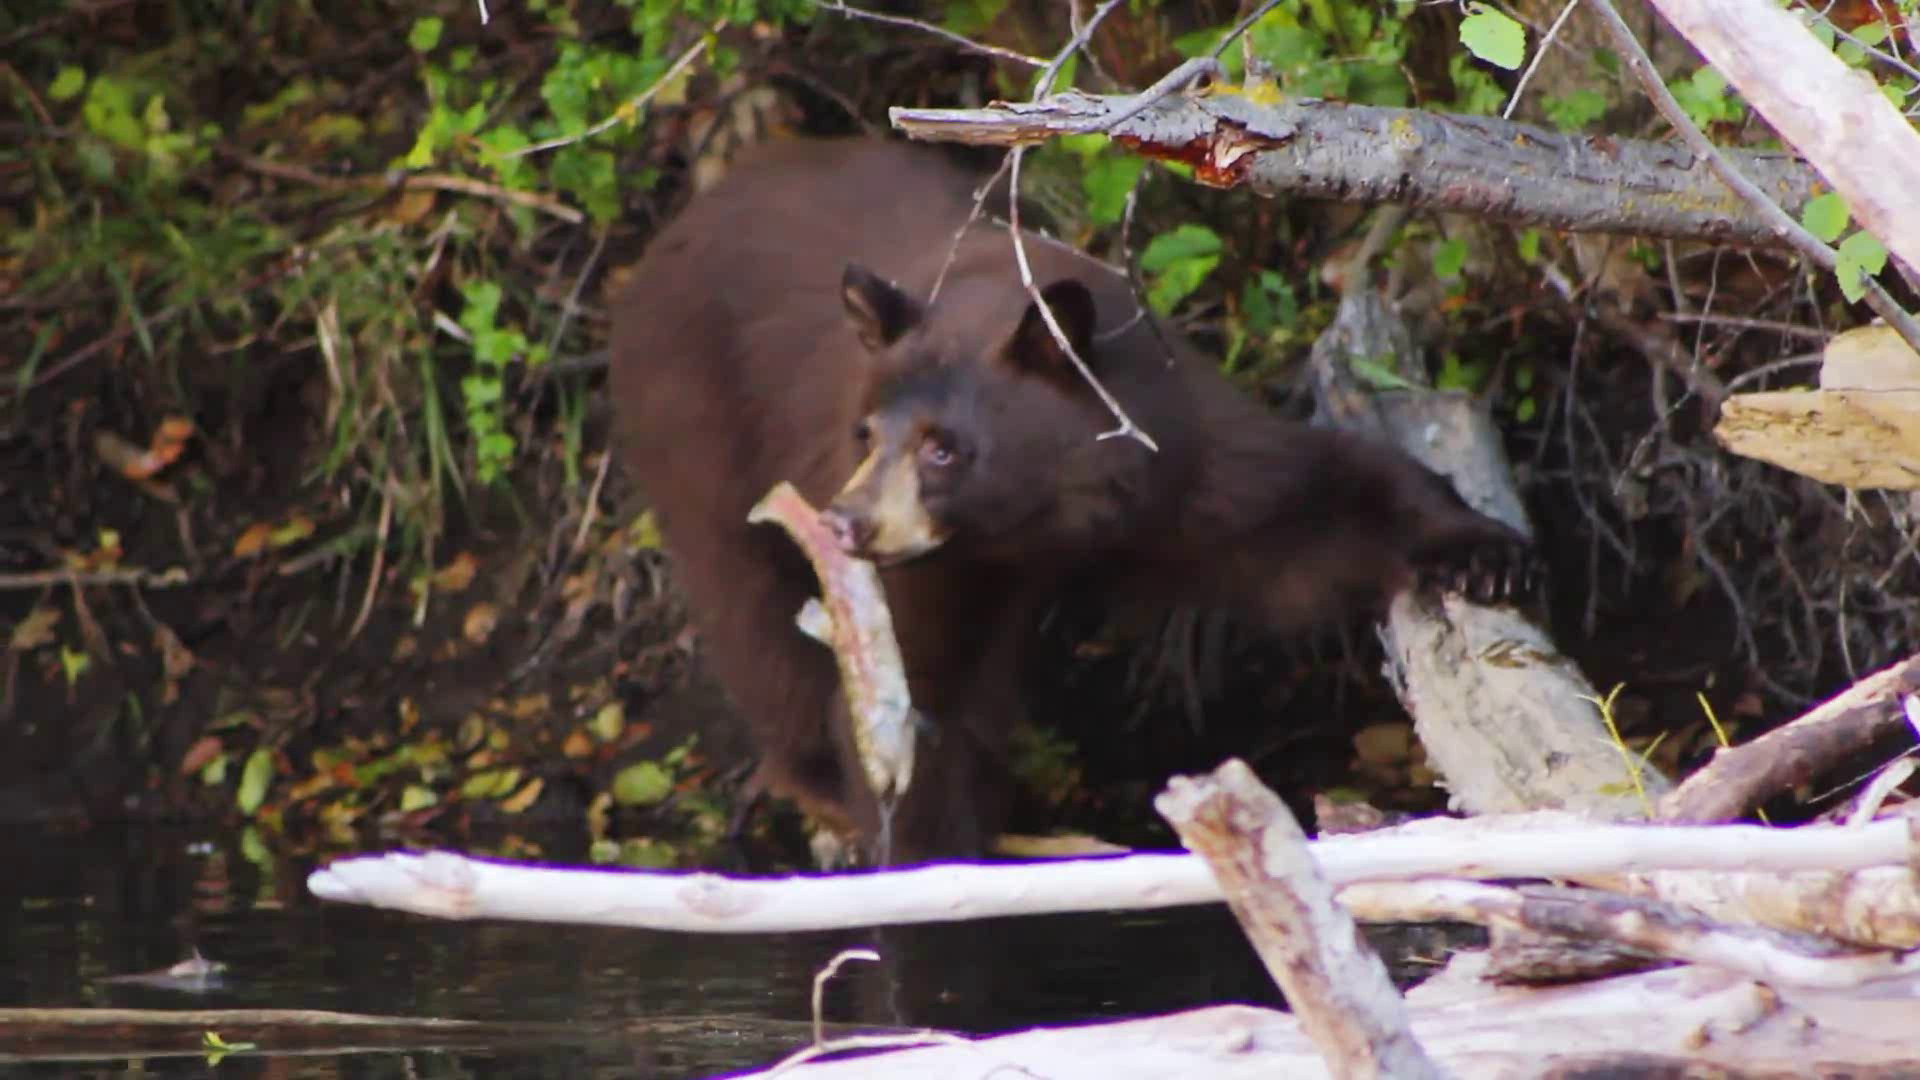

In [ ]:
const ffmpeg = require("fluent-ffmpeg") as typeof import("fluent-ffmpeg");
const stream = require("stream") as typeof import("stream");

function getFirstFrameBuffer(videoPath: string, codec = "png"): Promise<Buffer> {
  return new Promise((resolve, reject) => {
    const passthrough = new stream.PassThrough();
    const chunks = [];

    ffmpeg(videoPath)
      .inputOptions(["-ss", "0"])
      .frames(1)
      .format("image2pipe")
      .outputOptions(["-vcodec", codec])
      .on("error", reject)
      .pipe(passthrough, { end: true });

    passthrough.on("data", (chunk) => chunks.push(chunk));
    passthrough.on("end", () => {
      resolve(Buffer.concat(chunks));
    });
    passthrough.on("error", reject);
  });
}

const firstFrameBuffer = await getFirstFrameBuffer(VIDEO_FILE_PATH, "png");
tslab.display.png(new Uint8Array(firstFrameBuffer));


The uploaded video is ready to be analyzed. The constructed prompt instructs the model to classify animals in the video. In addition to providing both their English and Latin names.


In [21]:
const response = await ai.models.generateContent({
  model: MODEL_ID,
  contents: [
    "Please identify the animal(s) in this video",
    google.createPartFromUri(videoFile.uri ?? "", videoFile.mimeType ?? "video/webm"),
  ],
  config: {
    systemInstruction:
      "You are a zoologist whose job is to name animals in videos. You should always provide an english and latin name.",
  },
});
tslab.display.markdown(response.text ?? "No response text available");


Observing the video, I can identify:

**English Name:** American Black Bear (and an American Black Bear cub)
**Latin Name:** *Ursus americanus*

The adult bear, despite its brown coloration (which is common for American Black Bears, especially in western North America), exhibits the typical facial profile, rounded ears, and lack of a pronounced shoulder hump characteristic of *Ursus americanus*. The second, smaller individual emerging from the foliage is clearly a cub, indicating a mother and her offspring. Their behavior, particularly the attempt to catch fish and movement in and out of the water, is consistent with American Black Bear foraging activities in their natural habitat.

As you can see, the model accurately named the animal and provided a correct Latin name.

You can delete the video to prevent unnecessary data storage.


In [22]:
await ai.files.delete({
  name: videoFile.name ?? "",
});


DeleteFileResponse {}


## Summary

Now you know how you can prompt Gemini models with videos and use them to classify species of animals.

This notebook shows only one of many use cases. Check the [Video understanding notebook](../quickstarts/Video_understanding.ipynb) for more examples of using the Gemini API with videos.
